<a href="https://colab.research.google.com/github/cwkim0120/pnuemonia-diagnosis-lung-segmentation-masking/blob/main/chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#to upload files
from google.colab import files

#install Kaggle library 
!pip list
!pip install -q kaggle

In [ ]:
# upload kaggle API key file
uploaded = files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop

import requests
from io import BytesIO

import json
import zipfile

from random import sample
from datetime import datetime
from tqdm import tqdm, auto
import shutil
import os
import gc
import warnings
warnings.filterwarnings("ignore")

# Load Data

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (PNEUMONIA/NORMAL). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [ ]:
# download dataset <owner>/<dataset-name>
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

In [ ]:
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zf:
  zf.extractall()

img_dir = os.path.join(os.getcwd(), 'chest_xray')
test_img_dir = os.path.join(img_dir, 'test')
train_img_dir = os.path.join(img_dir, 'train')
val_img_dir = os.path.join(img_dir, 'val')

# EDA

In [ ]:
#title samples partition { display-mode: "form" }

NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P

NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P

NB_TOTAL_SAMPLES = NB_TRAIN_SAMPLES + NB_VAL_SAMPLES + NB_TEST_SAMPLES

def chart_partitioning():

  fig = plt.figure(figsize=(16,1))

  ax = fig.add_subplot(1,2,1)
  ax.barh(['VAL'], [NB_VAL_SAMPLES], color='#0000ff')
  ax.barh(['TEST'], [NB_TEST_SAMPLES], color='#0000ff')
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES], color='#0000ff')
  ax.set_xscale('log')
  ax.set_xlim((1,1e4))
  ax.set_title('n-Samples each partition');

  ax = fig.add_subplot(1,2,2)
  ax.barh(['VAL'], [NB_VAL_SAMPLES_N/NB_VAL_SAMPLES], color='#0000ff')
  ax.barh(['VAL'], [NB_VAL_SAMPLES_P/NB_VAL_SAMPLES], color='#ffff00',
          left=[NB_VAL_SAMPLES_N/NB_VAL_SAMPLES])
  ax.barh(['TEST'], [NB_TEST_SAMPLES_N/NB_TEST_SAMPLES], color='#0000ff')
  ax.barh(['TEST'], [NB_TEST_SAMPLES_P/NB_TEST_SAMPLES], color='#ffff00', 
          left=[NB_TEST_SAMPLES_N/NB_TEST_SAMPLES])
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES], color='#0000ff')
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_P/NB_TRAIN_SAMPLES], color='#ffff00', 
          left=[NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES])
  ax.set_xlim((0,1))
  ax.set_title('Normal-Pneumonia portion each partition');

  fig = plt.figure(figsize=(16,0.3))
  ax = fig.add_subplot(1,1,1)
  NB_TOTAL_SAMPLES = NB_TEST_SAMPLES + NB_TRAIN_SAMPLES + NB_VAL_SAMPLES
  ax.barh(['ALL'], [NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES], color='#0000ff')
  ax.barh(['ALL'], [NB_VAL_SAMPLES/NB_TOTAL_SAMPLES], color='#ffff00',
          left=[NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES])
  ax.barh(['ALL'], [NB_TEST_SAMPLES/NB_TOTAL_SAMPLES], color='#00ffff',
          left=[(NB_TRAIN_SAMPLES+NB_VAL_SAMPLES)/NB_TOTAL_SAMPLES])
  ax.set_xlim((0,1))
  ax.set_title('Overall partition');

chart_partitioning()

- Validation set too small, it caused high oscilation in the training process. Restructure train, val, test seems worthed, try **~80%, ~10%, ~10%** by moving some train samples to val.
- The imbalance class, there are mote pneumonia case in the dataset.

In [ ]:
# count how many samples to move so that train partition ~80%
train_part = NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES
n_to_move = round((train_part - 0.8) * NB_TRAIN_SAMPLES)
# count each n and p samples to move
# later train val have the same N/P proportion
n_to_move_N = round((NB_TRAIN_SAMPLES_N + NB_VAL_SAMPLES_N) /
                    (NB_TRAIN_SAMPLES + NB_VAL_SAMPLES) * n_to_move)
n_to_move_P = n_to_move - n_to_move_N

# move rendom files from one directory to other directory
def move_files_random(from_dir, to_dir, n):
  for filename in sample(os.listdir(from_dir), k=n):
    from_fpath = os.path.join(from_dir, filename)
    to_fpath = os.path.join(to_dir, filename)
    shutil.move(from_fpath, to_fpath)
  display(f"move {n} files from {from_dir} to {to_dir}")

move_files_random(from_dir=os.path.join(train_img_dir, 'NORMAL'),
                  to_dir=os.path.join(val_img_dir, 'NORMAL'),
                  n=n_to_move_N)

move_files_random(from_dir=os.path.join(train_img_dir, 'PNEUMONIA'),
                  to_dir=os.path.join(val_img_dir, 'PNEUMONIA'),
                  n=n_to_move_P)

In [ ]:
#@title samples partition after restructure { display-mode: "form" }

NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P

NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P

NB_TOTAL_SAMPLES = NB_TRAIN_SAMPLES + NB_VAL_SAMPLES + NB_TEST_SAMPLES

chart_partitioning()

# Data Generator

In [ ]:
#title set epoch, batch_size { display-mode: "form" }

EPOCHS = 25 #@param {type:"slider", min:5, max:30, step:1}
BATCH_SIZE =  100#@param {type:"number"}

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 150, 150

train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=8,  # degrees
                   zoom_range=0.1,
                   width_shift_range=0.08,  # per cent width
                   height_shift_range=0.08,  # per cent height
                   horizontal_flip=False,
                   vertical_flip=False,
                   shear_range=0.02,
                   )

train_generator = train_datagen.flow_from_directory(
                                   train_img_dir,
                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                   batch_size=BATCH_SIZE,
                                   class_mode='binary',
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = test_datagen.flow_from_directory(
                                val_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=BATCH_SIZE,
                                class_mode='binary',
                                )

test_generator = test_datagen.flow_from_directory(
                                test_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=32,
                                shuffle=False,
                                class_mode='binary',
                                )

Found 4743 images belonging to 2 classes.
Found 489 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


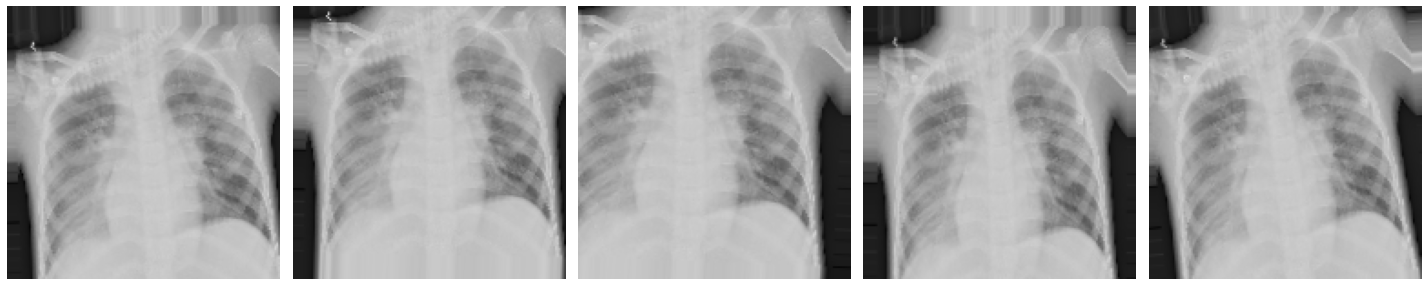

In [ ]:
#@title check posibilities of augmented images at training dataset { display-mode: "form" }

flow_n = 1 #@param {type:"slider", min:0, max:10, step:1}
idx_m = 10 #@param {type:"slider", min:0, max:99, step:1}

# This function will plot augmented images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show();

plotImages([train_generator[flow_n][0][idx_m] for i in range(5)])

- To resize the image so that all of the images have the same form: width of 150 and height of 150
- ImageDataGenerator augmentation might causes "bleeding" and crop important feature.
- It is crucial the chest area are fully included in the image. While in some images, the chest area is just fit so perfectly that even tiny slight parameter may crop them.

# Create Model

In [ ]:
#@title set optimizer and learning_rate{ display-mode: "form" }

optimizer = "RMSprop" #@param ["adam", "RMSprop"]
learning_rate = 0.0008 #@param {type:"number"}

optimizer = Adam(learning_rate=learning_rate) if optimizer == "adam" \
              else RMSprop(learning_rate=learning_rate)

In [ ]:
inputs = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3))
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
               input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Flatten()(model)
model = Dense(activation='relu', units=128)(model)S
outputs = Dense(activation='sigmoid', units=1)(model)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

loss = 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 41472)             0   

In [ ]:
gc.collect()

1854

# Fit Model

In [ ]:
history = model.fit_generator(
                      train_generator,
                      steps_per_epoch=NB_TRAIN_SAMPLES//BATCH_SIZE+1,
                      epochs=EPOCHS,
                      validation_data=val_generator,
                      validation_steps=NB_VAL_SAMPLES//BATCH_SIZE+1,
                      # callbacks=,
                      )

Epoch 1/25
48/48 [==============================] - 67s 1s/step - loss: 0.5793 - accuracy: 0.7339 - val_loss: 0.5768 - val_accuracy: 0.7648
Epoch 2/25
48/48 [==============================] - 66s 1s/step - loss: 0.3416 - accuracy: 0.8613 - val_loss: 0.1998 - val_accuracy: 0.9284
Epoch 3/25
48/48 [==============================] - 69s 1s/step - loss: 0.2599 - accuracy: 0.8977 - val_loss: 0.1561 - val_accuracy: 0.9427
Epoch 4/25
48/48 [==============================] - 69s 1s/step - loss: 0.2370 - accuracy: 0.9121 - val_loss: 0.2341 - val_accuracy: 0.9018
Epoch 5/25
48/48 [==============================] - 66s 1s/step - loss: 0.2250 - accuracy: 0.9127 - val_loss: 0.1659 - val_accuracy: 0.9305
Epoch 6/25
48/48 [==============================] - 70s 1s/step - loss: 0.2060 - accuracy: 0.9186 - val_loss: 0.1180 - val_accuracy: 0.9571
Epoch 7/25
48/48 [==============================] - 70s 1s/step - loss: 0.1984 - accuracy: 0.9203 - val_loss: 0.1338 - val_accuracy: 0.9468
Epoch 8/25
48/48 [==

In [ ]:
score = model.evaluate(test_generator,
                       steps=NB_TEST_SAMPLES//32+1,
                       )

20/20 [==============================] - 6s 251ms/step - loss: 0.3240 - accuracy: 0.9022


In [ ]:
#@title save model and log { display-mode: "form" }

# save model
timestamp = datetime.strftime(datetime.now(), "%m%d_%H%m")  #month day hour min
model_fname = f"sequential_{timestamp}"; display(model_fname)
#model.save(model_fname, save_format='h5')

log = {}
log['history'] = history.history
log['score'] = {'loss':score[0], 'accuracy':score[1]}
log['params'] = {'epoch':EPOCHS, 'batch_size':BATCH_SIZE,
                 'optimizer':str(optimizer), 'learning_rate': learning_rate, 
                 'loss':loss, 'metrics':str(metrics)}
log_fname = f"log_{timestamp}.json"; display(log_fname)

with open(log_fname, 'w') as f:
  json.dump(log, f)

'sequential_1210_0912'

'log_1210_0912.json'

# load model(이미 저장된 모델 사용시)

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/deeplearningmodel/sequential_1128_0811')

# Evaluation

In [ ]:
import seaborn as sns
sns.set(style='whitegrid')

def plot_metrics(fp, is_url=True):

  if is_url!=True:
    log = json.load(open(fp, 'r'))
  else:
    response = requests.get(fp)
    log = response.json()

  acc = log['history']['accuracy']
  loss = log['history']['loss']
  val_acc = log['history']['val_accuracy']
  val_loss = log['history']['val_loss']

  fig = plt.figure(figsize=(12, 6))

  ax = fig.add_subplot(1,2,1)
  ax.plot(np.arange(1,len(acc)+1), acc, label='train_accuracy')
  ax.plot(np.arange(1,len(val_acc)+1), val_acc, label='val_accuracy')
  ax.legend(loc='lower right')
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch #')
  ax.grid()

  ax = fig.add_subplot(1,2,2)
  ax.plot(np.arange(1,len(loss)+1), loss, label='train_loss')
  ax.plot(np.arange(1,len(val_loss)+1), val_loss, label='val_loss')
  ax.legend(loc='upper right')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch #')
  ax.yaxis.tick_right()
  ax.yaxis.set_label_position("right")
  ax.grid();

---
 RMSProp(learning_rate=0.00008), batch=100, epoch=25
---

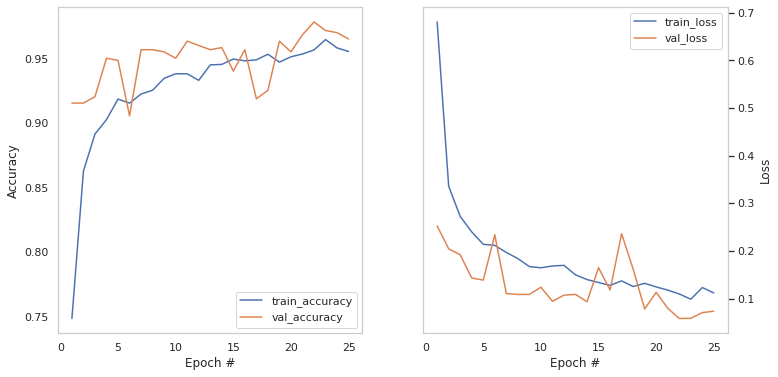

In [ ]:
#@title show result plot_metrics
#url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/log/log_0405_0604.json'
#plot_metrics(url, is_url=True)
url = '/content/drive/MyDrive/deeplearningmodel/log_1210_0912.json'
plot_metrics(url, is_url=False)

---
Restart and re-run
---

Found 624 images belonging to 2 classes.
20/20 [==============================] - 5s 241ms/step


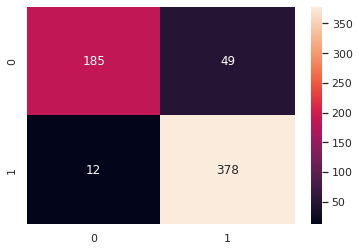

In [ ]:
#title confusion matrix on test dataset { display-mode: "form" }

import seaborn as sns
sns.set(style='whitegrid')

preds = model.predict(test_datagen.flow_from_directory(
                                test_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=32,
                                shuffle=False,
                                class_mode='binary'
                                ),
                      steps=NB_TEST_SAMPLES//32+1)

labels = np.vstack([np.zeros(shape=(NB_TEST_SAMPLES_N,1)),
                    np.ones(shape=(NB_TEST_SAMPLES_P,1))])

# Get the confusion matrix
cm  = tf.math.confusion_matrix(labels.flatten(), np.round(preds).flatten())
ax = sns.heatmap(cm.numpy(), annot=True, fmt="d")

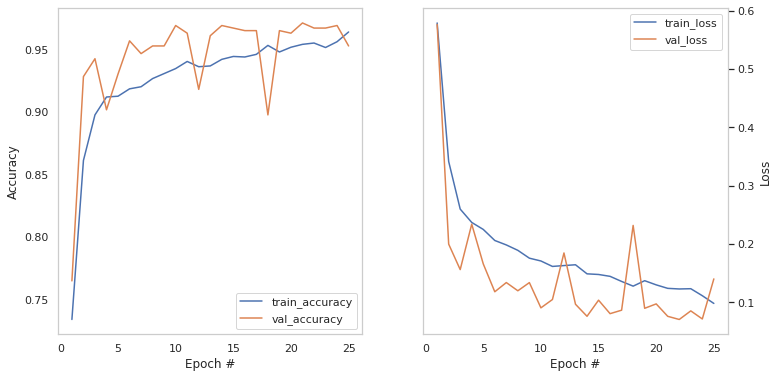

In [ ]:
#@title show result plot_metrics
plot_metrics(log_fname, is_url=False)

# pnuemonia segmentation

In [ ]:
# try image from other source

url_list = [
            # https://radiopaedia.org/cases/normal-chest-x-ray
            "https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_jumbo.jpg",
            # https://radiopaedia.org/cases/normal-chest-x-ray-1
            "https://prod-images-static.radiopaedia.org/images/8686421/17baee9bfb9018e3d109ec63cb380e_jumbo.jpeg",
            # https://radiopaedia.org/cases/lobar-pneumonia?lang=us
            "https://prod-images-static.radiopaedia.org/images/27547404/4e1dc09c3abe03a3efb72d494ddb6f_jumbo.jpeg",
            # https://radiopaedia.org/cases/round-pneumonia-8?lang=us
            "https://prod-images-static.radiopaedia.org/images/2394007/5d72614a0bb470df028956a4d303b0_jumbo.jpg", 

            ]

# for fn in uploaded.keys():
#   path = '/content/' + fn
#   img = load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT))
#   img = img_to_array(img)
#   img = np.expand_dims(img, axis=0)

for url in url_list:

  response = requests.get(url)
  # img = Image.open(BytesIO(response.content))
  img = load_img(BytesIO(response.content), target_size=(150, 150))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)

  classes = model.predict(img, batch_size=10)
  print(classes[0][0])
  if classes[0][0]>0.5:
    print(url + " is PNEUMONIA case")
  else:
    print(url + " is NORMAL case")

1/1 [==============================] - 7s 7s/step
1.0
https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_jumbo.jpg is PNEUMONIA case
1/1 [==============================] - 0s 20ms/step
1.0
https://prod-images-static.radiopaedia.org/images/8686421/17baee9bfb9018e3d109ec63cb380e_jumbo.jpeg is PNEUMONIA case
1/1 [==============================] - 0s 17ms/step
1.0
https://prod-images-static.radiopaedia.org/images/27547404/4e1dc09c3abe03a3efb72d494ddb6f_jumbo.jpeg is PNEUMONIA case
1/1 [==============================] - 0s 19ms/step
1.0
https://prod-images-static.radiopaedia.org/images/2394007/5d72614a0bb470df028956a4d303b0_jumbo.jpg is PNEUMONIA case


In [ ]:
!python -m pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pydicom
import glob
from PIL import Image
from skimage import io
import cv2

In [ ]:
plist = sorted(glob.glob('/content/drive/MyDrive/chest_x-ray/1.2.276.0.7230010.3.1.3.8323329*.dcm'))
print(len(plist))

256


주어진 dcm data를 info부분과 image부분으로 분할

In [ ]:
n = 0
image = []
dcm = []

for n in range (len(plist)):
  dcm_data =  pydicom.read_file(plist[n])
  dcm.append(dcm_data)
  image.append(dcm_data.pixel_array)

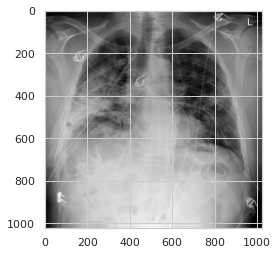

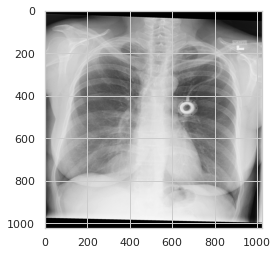

In [ ]:
plt.plot(1,2,1)
plt.imshow(image[18], cmap = 'gray')
plt.show()
plt.plot(1,2,2)
plt.imshow(image[19], cmap = 'gray')
plt.show()

In [ ]:
#img_name = 'example.jpg'
#img_path = os.path.join('/content/drive/MyDrive/chest_x-ray', img_name)

normal = 0
pnuemonia = 0
patient = []

for n in range(255):
  print(n)
  img = image[n]
  img = Image.fromarray(img)
  img.save('example2.jpg','JPEG')

  img_path = os.path.join('/content/example2.jpg')
  
  img = load_img(img_path, target_size=(150, 150))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  
  classes = model.predict(img, batch_size=10)
  print(classes)
  if classes > 0.5:
    print("This case" + " is PNEUMONIA case")
    pnuemonia += 1
    patient.append(image[n])

  else:
    print("This case" + " is NORMAL case")
    normal += 1


0
1/1 [==============================] - 0s 32ms/step
[[9.267258e-20]]
This case is NORMAL case
1
1/1 [==============================] - 0s 29ms/step
[[0.]]
This case is NORMAL case
2
1/1 [==============================] - 0s 34ms/step
[[0.]]
This case is NORMAL case
3
1/1 [==============================] - 0s 134ms/step
[[0.]]
This case is NORMAL case
4
1/1 [==============================] - 0s 22ms/step
[[0.]]
This case is NORMAL case
5
1/1 [==============================] - 0s 53ms/step
[[1.]]
This case is PNEUMONIA case
6
1/1 [==============================] - 0s 50ms/step
[[0.]]
This case is NORMAL case
7
1/1 [==============================] - 0s 29ms/step
[[1.]]
This case is PNEUMONIA case
8
1/1 [==============================] - 0s 36ms/step
[[1.]]
This case is PNEUMONIA case
9
1/1 [==============================] - 0s 32ms/step
[[1.]]
This case is PNEUMONIA case
10
1/1 [==============================] - 0s 54ms/step
[[1.]]
This case is PNEUMONIA case
11
1/1 [===================

In [ ]:
print("pnuemonia 환자 수 :", pnuemonia)
print("정상 환자 수 :", normal)
x = np.arange(3)
years = ['pneumonia', 'normal']
values = [pnuemonia, normal]

plt.bar(x, values)
plt.xticks(x, years)

plt.show()

pnuemonia 환자 수 : 61
정상 환자 수 : 194


# patient's lung segmentation & masking 

In [ ]:
import torch
import albumentations as A

In [ ]:
!pip install lungs-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lungs_segmentation.pre_trained_models import create_model

In [ ]:
model2 = create_model("resnet34")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)

In [ ]:
import lungs_segmentation.inference as inference

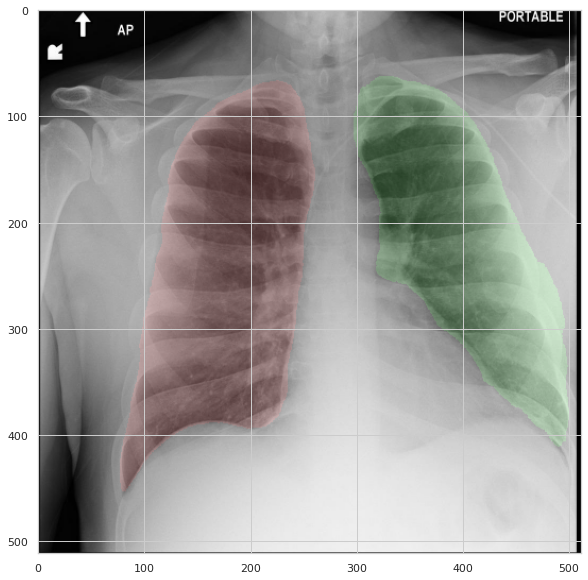

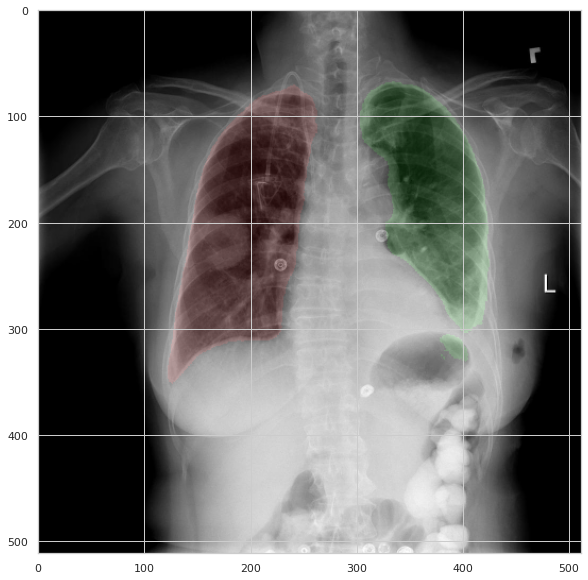

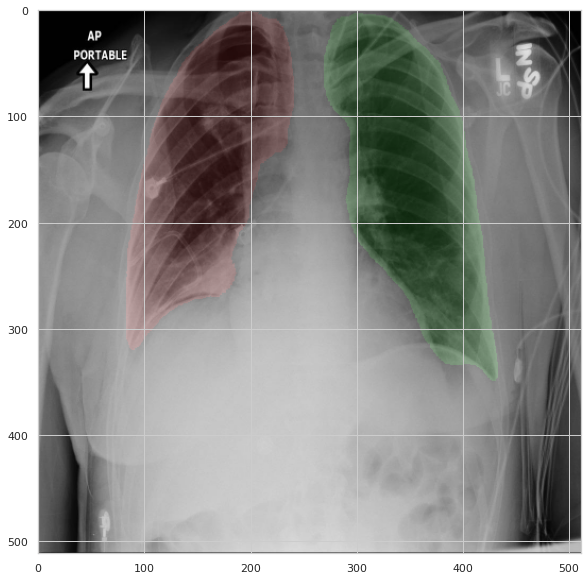

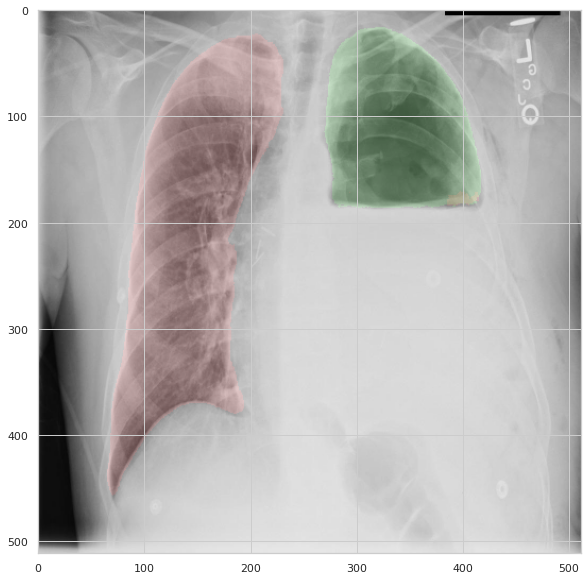

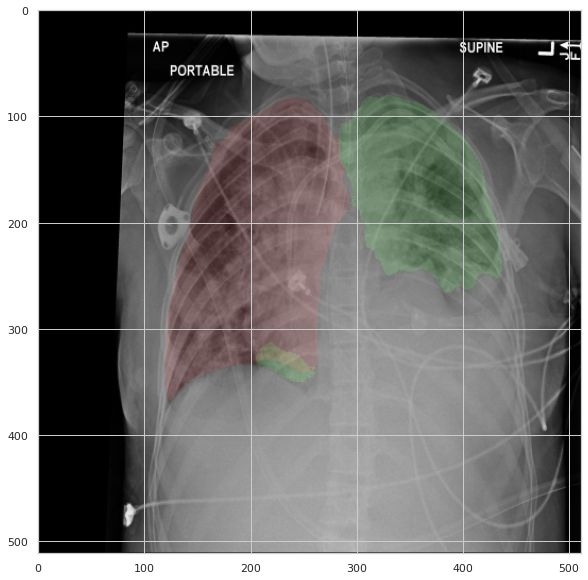

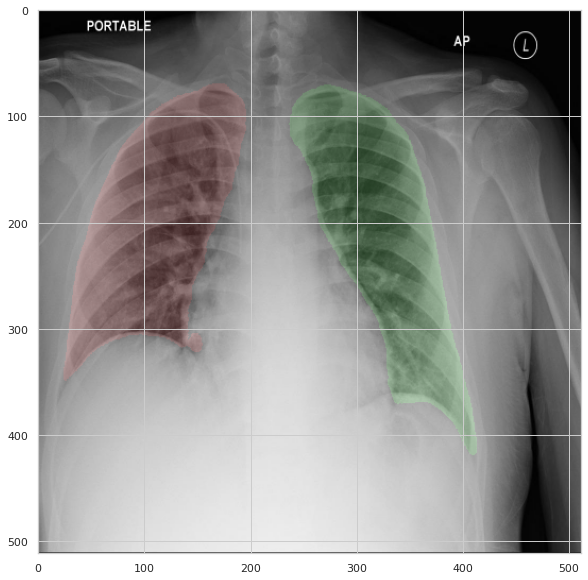

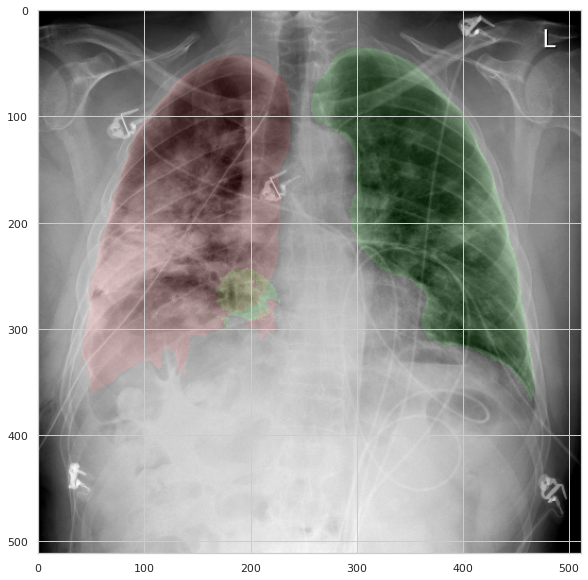

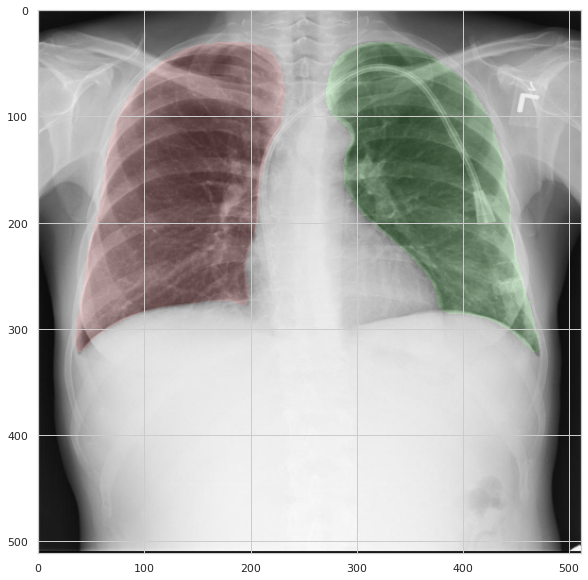

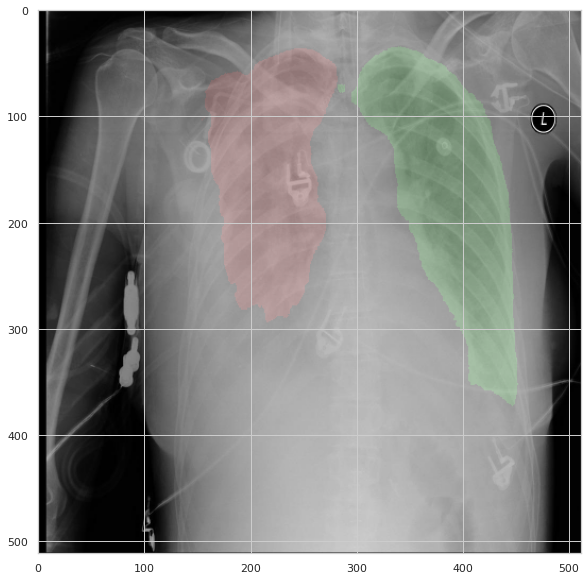

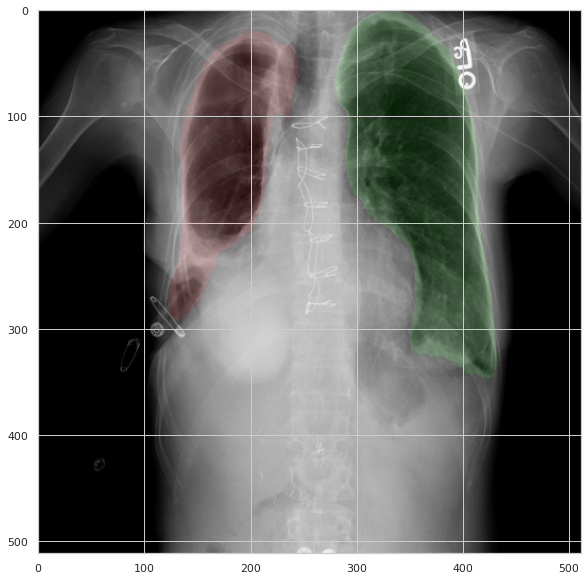

In [ ]:
for n in range(10):
  img = patient[n]
  img = Image.fromarray(img)
  img.save('example3.jpg','JPEG')
  image = ('/content/example3.jpg')

  plt.figure(figsize=(10,10))
  image, mask = inference.inference(model2,image, 0.2)
  plt.imshow(inference.img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))